In [1]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d


In [2]:
# import all the s2p files in Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA
import os
import glob
path = 'Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA'
s2p_files = glob.glob(os.path.join(path, '*.s2p'))

# update = True
update = False


In [3]:
# Load all s2p files into a list of Network objects
networks = [rf.Network(file) for file in s2p_files]
# fix the network names so that _1m, _2m,..._9m come before _10m
networks = sorted(networks, key=lambda x: (x.name[:-2], int(x.name[-2:]) if x.name[-2:].isdigit() else float('inf')))

In [4]:
# plot the S12 parameter for all networks and save the figure as a PNG file named after the file it corresponds to
dir = 'My S12/'
if update:
    for net in networks:
        # if net.name == 'Aug4_hpol_down_25m':
        # print(net.name)
        plt.figure(figsize=(10, 6))
        # plt.plot(net.f, 20 * np.log10(np.abs(net.s[:, 1, 0])), label=net.name, linewidth=0.3)
        plt.plot(net.f, 10 * np.log10(np.abs(net.s[:, 1, 0])), label=net.name, linewidth=0.3)
        plt.title(f'S12 Parameter for {net.name}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('S12 (dB)')
        plt.grid()
        plt.legend()
        plt.savefig(f'{dir}{net.name[5:]}.png', dpi=300, bbox_inches='tight')
        plt.close()

# Calculate the Friis equation for each network and plot the results
### The Friis equation is given by:
# $P_r = \frac{P_t G_t G_r \lambda^2}{(4 \pi d)^2}$
- $P_r$ is the received power
- $P_t$ is the transmitted power
    - [ ] what should this be? - placeholder of 1 Watt used
- $G_t$ is the gain of the transmitting antenna
- $G_r$ is the gain of the receiving antenna
- $\lambda$ is the wavelength
- $d$ is the distance between the antennas
    - [ ] get from the station json file - placeholder of 1 meter used
# $G_i(w) = \frac{4 \pi R}{\lambda} |S_{21}(w)|$
- per Mohammad's formulas

In [5]:
# grab all files from both directories
HPol_path = 'Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA'
VPol_path = 'Data/Port1inNWhole_Port2inShole_ST35_VPOL_VNA'
s2p_files_HPol = glob.glob(os.path.join(HPol_path, '*.s2p'))
s2p_files_VPol = glob.glob(os.path.join(VPol_path, '*.s2p'))
# Load all s2p files into a single list of Network objects
networks = [rf.Network(file) for file in s2p_files_HPol + s2p_files_VPol]
networks = sorted(networks, key=lambda x: (x.name[:-2], int(x.name[-2:]) if x.name[-2:].isdigit() else float('inf')))

d = 34.63  # Distance according to station json file in meters
# TODO: figure out which is the correct distance to use
# the json method assumes that the NRMC coord system is in meters and the layour is an equilateral triangle

In [6]:
dir = 'Gain Plots/'

if update:
    for net in networks:
        # print(net.name)
        # if net.name != 'Aug4_hpol_down_25m':
        #     continue  # Skip this network for now
        plt.figure(figsize=(10, 4))

        # calculate the gain of the antenna from the S12 parameter
        wavelength = 3e8 / net.f  # Wavelength in meters
        G_i = (4 * np.pi * d) / wavelength * np.abs(net.s[:, 1, 0])


        smoothed_G_i = gaussian_filter1d(G_i, sigma=20)  # Smooth the gain
        # plot the gain
        plt.plot(net.f, 10 * np.log10(G_i), label=net.name, linewidth=0.3)
        plt.plot(net.f, 10 * np.log10(smoothed_G_i), label=net.name + ' (smoothed)', linewidth=1)
        plt.title('Gain of Antenna from S12 Parameter')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain (dB)')
        plt.grid()
        plt.savefig(f'{dir}{net.name[5:]}_triangle_solver.png', dpi=300, bbox_inches='tight')
        plt.close()

# Gain looks ok, now figure out RVEL

# $\mathcal{H}_i(w) = \lambda \sqrt{\frac{Z_0}{4 \pi Z_f} G_i(w)}$m
- $Z_0$ is 50 Ohms
- $Z_f$ is the free space impedance (377 Ohms)
- $G_i(w)$ is the gain of the antenna


In [7]:
# Constants we know
Z_f = 377  # Free space impedance in Ohms
# n = 1.32  # Refractive index of the medium (Greenland Firn)
Z_0 = 50.0  # Characteristic impedance of the antenna in Ohms

In [8]:
def get_RVEL(network, G_i):
    wavelength = 3e8 / network.f  # Wavelength in meters
    RVEL = wavelength * np.sqrt(((Z_0) / (4 * np.pi * Z_f)) * G_i)  # Antenna impedance calculation

    return RVEL

In [9]:
# load the NuRadioMC VELS data
import pickle
from NuRadioReco.utilities import units

with open('NuRadio_VELS_dict.pkl', 'rb') as f:
    NuRadio_VELS_dict = pickle.load(f)

In [10]:
# print the keys of the NuRadio_VELS_dict
for key in NuRadio_VELS_dict.keys():
    print(key)

RNOG vpol 4in center n=1.73
RNOG vpol 4in half n=1.73
RNOG vpol 4in wall n=1.73
RNOG vpol 3.5in center n=1.74
RNOG hpol v4.8in center n=1.74


In [11]:
# print the first few theta values from RNOG vpol 4in center n=1.73
print(NuRadio_VELS_dict['RNOG vpol 4in center n=1.73']['theta'][:5])
print()
print(NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']['theta'][:5])

[0.00164018-0.05167562j 0.00398137-0.05258851j 0.00632257-0.0535014j
 0.00866376-0.0544143j  0.01100495-0.05532719j]

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [12]:
dir = 'RVEL Plots/'
ff = np.linspace(50 * units.MHz, 1 * units.GHz, 1000)

if update:
    for net in networks:
        # if net.name != 'Aug4_hpol_down_25m':
        # if net.name != 'Aug4_vpol_down_1m':
        #     continue

        # print(net.name[5:6])

        wavelength = 3e8 / net.f  # Wavelength in meters
        G_i = (4 * np.pi * d) / wavelength * np.abs(net.s[:, 1, 0])
        RVEL = get_RVEL(net, G_i)
        smoothed_RVEL = gaussian_filter1d(RVEL, sigma=20)  #

        plt.figure(figsize=(10, 4))
        # plt.plot(net.f, RVEL, label=net.name, linewidth=0.3)
        plt.plot(net.f, smoothed_RVEL, label=net.name + ' (smoothed)', linewidth=1)
        # plt.plot(ff / units.Hz, NuRadio_VELS['theta'], label='NuRadioMC VELS', linewidth=1)

        if net.name[5:6] == 'h':
            NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)

        else:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 4in center n=1.73']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1)


        plt.title(f'RVEL for {net.name}')
        plt.xlabel('Frequency (Hz)')
        # plt.xlim(.08e9, 1e9)
        plt.ylabel('RVEL (m)')
        # plt.ylim(0, 0.2)  # Set y-axis limits to focus on the RVEL
        plt.grid()
        plt.legend()
        plt.savefig(f'{dir}{net.name[5:]}_RVEL.png', dpi=300, bbox_inches='tight')
        plt.close()

        plt.figure(figsize=(10, 4))
        # plt.plot(net.f, RVEL, label=net.name, linewidth=0.3)
        plt.plot(net.f, smoothed_RVEL, label=net.name + ' (smoothed)', linewidth=1)
        # plt.plot(ff / units.Hz, NuRadio_VELS['theta'], label='NuRadioMC VELS', linewidth=1)

        if net.name[5:6] == 'h':
            NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)

        else:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 4in center n=1.73']
            plt.plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1)


        plt.title(f'RVEL for {net.name}')
        plt.xlabel('Frequency (Hz)')
        # plt.xlim(.08e9, 1e9)
        plt.ylabel('RVEL (m)')
        plt.ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        plt.grid()
        plt.legend()
        plt.savefig(f'{dir}{net.name[5:]}_RVEL_zoomed.png', dpi=300, bbox_inches='tight')
        plt.close()


In [13]:
# dir = 'Tri Plots'
#
# for net in networks:
#     # if net.name != 'Aug4_hpol_down_25m':
#     #     continue
#     # continue  # Skip this network for now
#     print(f'Plotting for {net.name}')
#     wavelength = 3e8 / net.f
#     S_12 = np.abs(net.s[:, 1, 0])
#     smoothed_S_12 = gaussian_filter1d(S_12, sigma=20)
#     G_i = (4 * np.pi * d) / wavelength * S_12
#     smoothed_G_i = gaussian_filter1d(G_i, sigma=20)
#     RVEL = get_RVEL(net, G_i)
#     smoothed_RVEL = gaussian_filter1d(RVEL, sigma=20)
#
#     # make three subplots in one figure
#     fig, axs = plt.subplots(3, 1, figsize=(10, 10))
#     plt.suptitle(f'Data for {net.name}')
#     axs[0].plot(net.f, 10 * np.log10(smoothed_S_12), label=net.name + ' S12 (smoothed)', linewidth=1)
#     axs[0].set_title('S12 Parameter')
#     # axs[0].set_xlabel('Frequency (Hz)')
#     axs[0].set_ylabel('S12 (dB)')
#     axs[0].set_ylim(-45, -20)  # Set y-axis limits to focus on the S12 parameter
#     axs[0].grid()
#     axs[0].legend()
#
#     axs[1].plot(net.f, 10 * np.log10(smoothed_G_i), label=net.name + ' Gain (smoothed)', linewidth=1)
#     axs[1].set_title('Gain of Antenna from S12 Parameter')
#     # axs[1].set_xlabel('Frequency (Hz)')
#     axs[1].set_ylabel('Gain (dB)')
#     axs[1].set_ylim(-20, 6)
#     axs[1].grid()
#     axs[1].legend()
#     # print(f"max gain for {net.name}: {np.max(10 * np.log10(smoothed_G_i)):.2f} dB")
#
#     axs[2].plot(net.f, smoothed_RVEL, label=net.name + ' RVEL (smoothed)', linewidth=1)
#     axs[2].set_title('RVEL')
#     axs[2].set_xlabel('Frequency (Hz)')
#     axs[2].set_ylabel('RVEL (m)')
#     axs[2].set_ylim(0, 0.85)  # Set y-axis limits to focus on the RVEL
#     axs[2].grid()
#     axs[2].legend()
#     plt.tight_layout()
#     plt.savefig(f'{dir}/{net.name[5:]}_tri_plot.png', dpi=300, bbox_inches='tight')
#     plt.close(fig)

In [83]:

ff = np.linspace(50 * units.MHz, 1 * units.GHz, 1000)

# sort the networks by name
# networks = sorted(networks, key=lambda x: x.name)
num_networks = len(networks)
print(f'Number of networks: {num_networks}')

hpol_down_networks = [net for net in networks if 'hpol_down' in net.name]
hpol_up_networks = [net for net in networks if 'hpol_up' in net.name]
vpol_networks = [net for net in networks if 'vpol' in net.name]

print(len(hpol_down_networks), len(vpol_networks))

# make an array of the networks that are hpol down, their name, wavelength, Gain, and RVEL
hpol_down = []
for i, net in enumerate(hpol_down_networks):
    # print(f'Plotting for {net.name}')
    wavelength = 3e8 / net.f
    S_12 = np.abs(net.s[:, 1, 0])
    smoothed_S_12 = gaussian_filter1d(S_12, sigma=20)
    G_i = (4 * np.pi * d) / wavelength * S_12
    smoothed_G_i = gaussian_filter1d(G_i, sigma=20)
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=20)
    hpol_down.append({
        'name': net.name,
        'frequency': net.f,
        'wavelength': wavelength,
        'S_12': S_12,
        'smoothed_S_12': smoothed_S_12,
        'G_i': G_i,
        'smoothed_G_i': smoothed_G_i,
        'RVEL': RVEL,
        'smoothed_RVEL': smoothed_RVEL
    })

hpol_up = []
for i, net in enumerate(hpol_up_networks):
    # print(f'Plotting for {net.name}')
    wavelength = 3e8 / net.f
    S_12 = np.abs(net.s[:, 1, 0])
    smoothed_S_12 = gaussian_filter1d(S_12, sigma=20)
    G_i = (4 * np.pi * d) / wavelength * S_12
    smoothed_G_i = gaussian_filter1d(G_i, sigma=20)
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=20)
    hpol_up.append({
        'name': net.name,
        'frequency': net.f,
        'wavelength': wavelength,
        'S_12': S_12,
        'smoothed_S_12': smoothed_S_12,
        'G_i': G_i,
        'smoothed_G_i': smoothed_G_i,
        'RVEL': RVEL,
        'smoothed_RVEL': smoothed_RVEL
    })

vpol = []
for i, net in enumerate(vpol_networks):
    # print(f'Plotting for {net.name}')
    wavelength = 3e8 / net.f
    S_12 = np.abs(net.s[:, 1, 0])
    smoothed_S_12 = gaussian_filter1d(S_12, sigma=20)
    G_i = (4 * np.pi * d) / wavelength * S_12
    smoothed_G_i = gaussian_filter1d(G_i, sigma=20)
    RVEL = get_RVEL(net, G_i)
    smoothed_RVEL = gaussian_filter1d(RVEL, sigma=20)
    vpol.append({
        'name': net.name,
        'frequency': net.f,
        'wavelength': wavelength,
        'S_12': S_12,
        'smoothed_S_12': smoothed_S_12,
        'G_i': G_i,
        'smoothed_G_i': smoothed_G_i,
        'RVEL': RVEL,
        'smoothed_RVEL': smoothed_RVEL
    })


# print the first three names of the hpol_down networks
for net in hpol_down_networks[:3]:
    print(net.name)

Number of networks: 99
51 37
Aug4_hpol_down_1m
Aug4_hpol_down_2m
Aug4_hpol_down_3m


In [112]:
# plot each of the 50 hpol down files in a column of subplots
dir = 'RVEL Plots'

# network_list = hpol_down
# network_list = hpol_up
network_list = vpol

vpol_peaks = []

if not update:
    fig, axs = plt.subplots(len(network_list), 1, figsize=(10, 3 * len(network_list)), sharex=True)
    for i, net in enumerate(network_list):
        name = net['name'][5:]  # remove the Aug4_ part of the name
        # print(f'Plotting for {name}')
        axs[i].plot(net['frequency'], net['smoothed_RVEL'], label=net['name'] + ' RVEL (smoothed)', linewidth=1)
        # plot the NuRadioMC RVELs
        if 'hpol' in name:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
            axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)
        if 'vpol'  in name:
            NuRadio_VELS = NuRadio_VELS_dict['RNOG vpol 4in center n=1.73']
            axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['theta']), label='NuRadioMC RVELS', linewidth=1)
            # find the peak VNA RVEL above 100 MHz and draw a vertical line there with a label for the frequency
            peak_index = np.argmax(net['smoothed_RVEL'][net['frequency'] >= 100e6])
            peak_freq = net['frequency'][net['frequency'] >= 100e6][peak_index]
            peak_RVEL = net['smoothed_RVEL'][net['frequency'] >= 100e6][peak_index]
            axs[i].axvline(peak_freq, color='blue', linestyle='--', label=f'Peak VNA RVEL at {peak_freq/1e6:.1f} MHz')
            vpol_peaks.append((name, peak_freq, peak_RVEL))

            # find the peak NuRadio RVEL above 100 MHz and draw a vertical line there with a label for the frequency
            peak_index_nu = np.argmax(np.abs(NuRadio_VELS['theta'][ff >= 100 * units.MHz]))
            peak_freq_nu = ff[ff >= 100 * units.MHz][peak_index_nu] / units.Hz
            peak_RVEL_nu = np.abs(NuRadio_VELS['theta'][ff >= 100 * units.MHz][peak_index_nu])
            axs[i].axvline(peak_freq_nu, color='orange', linestyle='--', label=f'Peak NuRadio RVEL at {peak_freq_nu/1e6:.1f} MHz')


        axs[i].set_title(f'RVEL for {name}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('RVEL (m)')
        axs[i].tick_params(axis='x', which='both', labelbottom=True)
        if 'hpol' in name:
            axs[i].set_ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
        if 'vpol' in name:
            axs[i].set_ylim(0, 0.25)  # Set y-axis limits to focus on the RVEL
        axs[i].grid()
        axs[i].legend()

    # axs[-1].set_xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(f'{dir}/all {name[:-4]}_RVEL.pdf', dpi=300, bbox_inches='tight')
    plt.close()

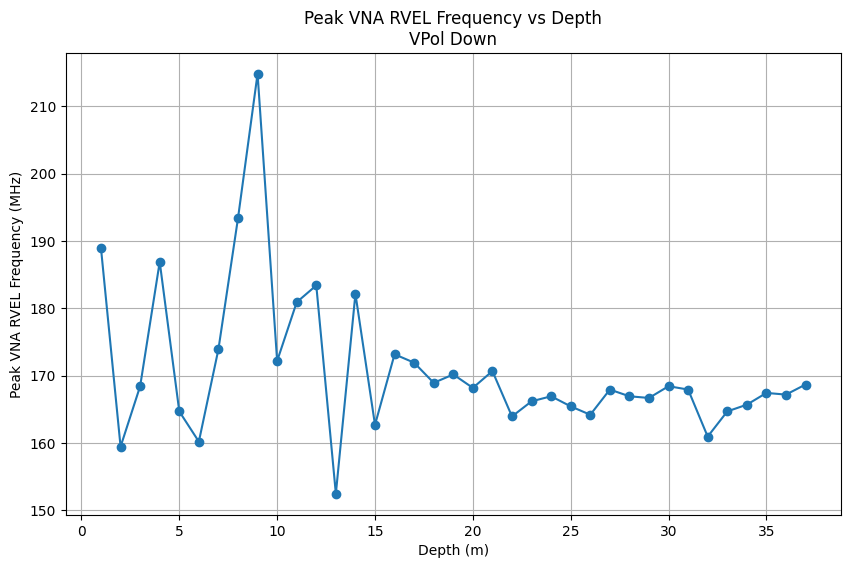

In [115]:
# plot how the peak VNA frequency changes with depth for vpol
depths = [int(peak[0].split('_')[-1][:-1]) for peak in vpol_peaks]  # get the depths in meters as integers
peak_freqs = [peak[1] for peak in vpol_peaks]
peak_RVELs = [peak[2] for peak in vpol_peaks]
plt.figure(figsize=(10, 6))
plt.plot(depths, np.array(peak_freqs) / 1e6, label='Peak VNA RVEL Frequency', marker='o')
plt.title('Peak VNA RVEL Frequency vs Depth\nVPol Down')
plt.xlabel('Depth (m)')
plt.ylabel('Peak VNA RVEL Frequency (MHz)')
# plt.ylim(0, 1000)
plt.grid()
plt.savefig(f'{dir}/peak VNA RVEL frequency vs depth - vpol_down.png', dpi=300, bbox_inches='tight')

#TODO: see if there's a better way to calculate the peak frequency, there is probably some error introduced by smoothing

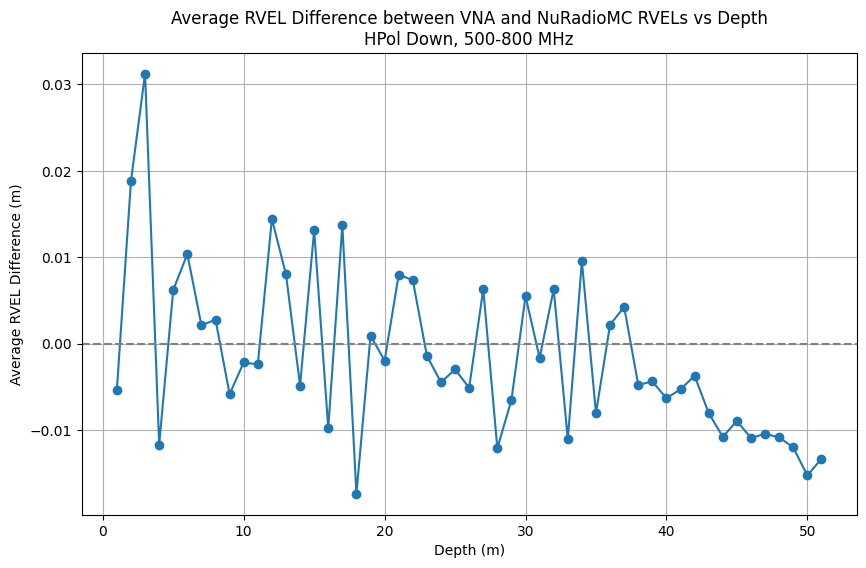

In [69]:
# measure the average difference between the VNA and NuRadioMC RVELs for hpol down between 200 MHz and 800 MHz
differences = []
VNA_ave_RVELs = []
Nuradio_ave_RVELs = []

difference = None
f_lower = 500  # MHz
f_upper = 800  # MHz
for i, net in enumerate(network_list):
    depth = net.name.split('_')[-1]  # get the depth from the name
    net_indices = np.where((net.f >= f_lower * 1e6) & (net.f <= f_upper * 1e6))[0]  # get indices in the frequency range
    # get the indices of ff between 200 MHz and 800 MHz
    ff_indices = np.where((ff >= f_lower * units.MHz) & (ff <= f_upper * units.MHz))[0]

    VNA_RVEL = hpol_down[i]['smoothed_RVEL'][net_indices]
    NuRadio_RVEL = np.abs(NuRadio_VELS['phi'][ff_indices])

    ave_VNA_RVEL = np.mean(VNA_RVEL)
    ave_NuRadio_RVEL = np.mean(NuRadio_RVEL)
    VNA_ave_RVELs.append(ave_VNA_RVEL)
    Nuradio_ave_RVELs.append(ave_NuRadio_RVEL)
    difference = ave_VNA_RVEL - ave_NuRadio_RVEL
    differences.append((depth, difference))

# plot the differences and areas as a function of depth
depths = [int(net.name.split('_')[-1][:-1]) for net in hpol_down_networks]  # get the depths in meters as integers
diff_values = [diff[1] for diff in differences]
plt.figure(figsize=(10, 6))
# put the network name next to each point
# for i, net in enumerate(hpol_down_networks):
#     depth = net.name.split('_')[-1]  # get the depth from the name
#     plt.text(depths[i], diff_values[i], f'{depth}', fontsize=8, ha='right', va='bottom')
plt.plot(depths, diff_values, label='Average Difference', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Average RVEL Difference between VNA and NuRadioMC RVELs vs Depth\nHPol Down, {f_lower}-{f_upper} MHz')
plt.xlabel('Depth (m)')
# plot every other x tick
# plt.xticks(depths)
plt.ylabel('Average RVEL Difference (m)')
# plt.ylim(0,0.06)
plt.grid()

plt.savefig(f'{dir}/average RVEL Difference - hpol_down_{f_lower}-{f_upper}MHz.png', dpi=300, bbox_inches='tight')

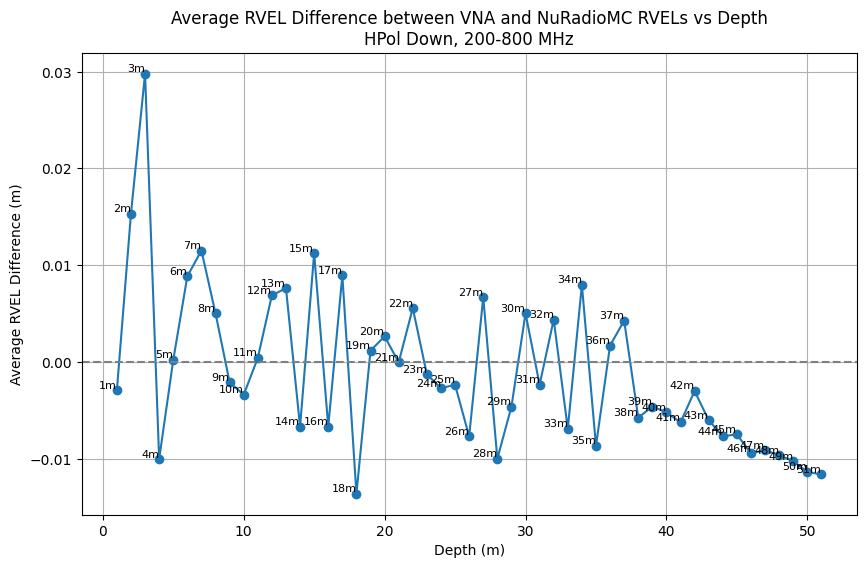

In [58]:
# plot the differences and areas as a function of depth
depths = [int(net.name.split('_')[-1][:-1]) for net in hpol_down_networks]  # get the depths in meters as integers
diff_values = [diff[1] for diff in differences]
plt.figure(figsize=(10, 6))
# put the network name next to each point
for i, net in enumerate(hpol_down_networks):
    depth = net.name.split('_')[-1]  # get the depth from the name
    plt.text(depths[i], diff_values[i], f'{depth}', fontsize=8, ha='right', va='bottom')
plt.plot(depths, diff_values, label='Average Difference', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Average RVEL Difference between VNA and NuRadioMC RVELs vs Depth\nHPol Down, {f_lower}-{f_upper} MHz')
plt.xlabel('Depth (m)')
# plot every other x tick
# plt.xticks(depths)
plt.ylabel('Average RVEL Difference (m)')
# plt.ylim(0,0.06)
plt.grid()

plt.savefig(f'{dir}/average RVEL Difference - hpol_down_{f_lower}-{f_upper}MHz.png', dpi=300, bbox_inches='tight')

In [55]:
# plot each of the 50 hpol down files in a column of subplots
dir = 'RVEL Plots'
if not update:
    fig, axs = plt.subplots(len(hpol_down_networks), 1, figsize=(10, 3 * len(hpol_down_networks)), sharex=True)
    for i, net in enumerate(hpol_down_networks):
        axs[i].plot(net.f, hpol_down[i]['smoothed_RVEL'], label=net.name + ' RVEL (smoothed)', linewidth=1)
        NuRadio_VELS = NuRadio_VELS_dict['RNOG hpol v4.8in center n=1.74']
        axs[i].plot(ff / units.Hz, np.abs(NuRadio_VELS['phi']), label='NuRadioMC RVELS', linewidth=1)

        # draw the average VNA_ave_RVELs and Nuradio_ave_RVELs between f_lower and f_upper MHz
        depth = net.name.split('_')[-1]  # get the depth from the name

        net_indices = np.where((net.f >= f_lower * 1e6) & (net.f <= f_upper * 1e6))[0]  # get indices between 200 MHz and 800 MHz
        # draw a line for the average VNA RVEL
        axs[i].hlines(VNA_ave_RVELs[i], net.f[net_indices[0]], net.f[net_indices[-1]], colors='r', linestyles='--', label='Average VNA RVEL', linewidth=1, color='blue')
        # draw a line for the average NuRadio RVEL
        axs[i].hlines(Nuradio_ave_RVELs[i], net.f[net_indices[0]], net.f[net_indices[-1]], colors='g', linestyles='--', label='Average NuRadio RVEL', linewidth=1, color='orange')

        axs[i].set_title(f'RVEL for {net.name}')
        # set the x axis ticks to be every 100 MHz starting at 100 MHz and ending at 1 GHz
        axs[i].xaxis.set_major_locator(plt.MultipleLocator(100e6))
        axs[i].set_xlim(0, 1e9)
        # draw the x axis numerical labels in each subplot
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('RVEL (m)')
        axs[i].tick_params(axis='x', which='both', labelbottom=True)
        axs[i].set_ylim(0, 0.12)  # Set y-axis limits to focus on the RVEL
        axs[i].grid()
        axs[i].legend()

    # axs[-1].set_xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(f'{dir}/all hpol_down_RVEL.pdf', dpi=300, bbox_inches='tight')
    plt.close()

In [18]:
# repeat for vpol


In [19]:
#